## Analysis of FF Endometrial Adenocarcinoma Dataset

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sns
import csv
from sklearn.metrics.pairwise import cosine_distances

import SpatialDE

plt.rcParams['figure.figsize']=(8,8)


%load_ext autoreload
%autoreload 2


### First pre-process data with scanpy

In [3]:
##Load in data
ff_human_ovarian_cancer = sc.datasets.visium_sge('Parent_Visium_Human_OvarianCancer')
ff_human_ovarian_cancer.var_names_make_unique()

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 6.84M/6.84M [00:01<00:00, 6.76MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 16.1M/16.1M [00:01<00:00, 8.68MB/s]
/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
ff_human_ovarian_cancer

AnnData object with n_obs × n_vars = 3493 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
#Calculate some QC metrics for the data
ff_human_ovarian_cancer.var["mt"] = ff_human_ovarian_cancer.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(ff_human_ovarian_cancer, qc_vars=["mt"], inplace=True)

In [6]:
##Filter by MT values
ff_human_ovarian_cancer = ff_human_ovarian_cancer[ff_human_ovarian_cancer.obs["pct_counts_mt"] < 15]
ff_human_ovarian_cancer = ff_human_ovarian_cancer[ff_human_ovarian_cancer.obs["pct_counts_mt"] > 2]

In [7]:
ff_human_ovarian_cancer.var["mt"]
ff_human_ovarian_cancer.var.sort_values(by=['mt'])

,gene_ids,feature_types,genome,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0.0,0.000000
RAB15,ENSG00000139998,Gene Expression,GRCh38,False,214,0.065273,0.063231,93.873461,228.0,5.433722
GPX2,ENSG00000176153,Gene Expression,GRCh38,False,2,0.000573,0.000572,99.942743,2.0,1.098612
CHURC1,ENSG00000258289,Gene Expression,GRCh38,False,1818,0.846837,0.613474,47.953049,2958.0,7.992607
SPTB,ENSG00000070182,Gene Expression,GRCh38,False,16,0.004867,0.004855,99.541941,17.0,2.890372
...,...,...,...,...,...,...,...,...,...,...
MT-ND1,ENSG00000198888,Gene Expression,GRCh38,True,3493,72.984543,4.303856,0.000000,254935.0,12.448768
MT-ND6,ENSG00000198695,Gene Expression,GRCh38,True,238,0.073862,0.071262,93.186373,258.0,5.556828
MT-CYB,ENSG00000198727,Gene Expression,GRCh38,True,3489,34.320927,3.564476,0.114515,119883.0,11.694280
MT-ND4,ENSG00000198886,Gene Expression,GRCh38,True,3493,90.724876,4.518794,0.000000,316902.0,12.666351


In [8]:
ff_human_ovarian_cancer.obs

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
AAACAAGTATCTCCCA-1,1,50,102,2460,7.808323,4752.0,8.466531,23.106061,31.439394,40.551347,55.239899,393.0,5.976351,8.270202
AAACACCAATAACTGC-1,1,59,19,3842,8.254009,10543.0,9.263312,29.887129,38.594328,46.618610,57.839325,1436.0,7.270313,13.620413
AAACAGGGTCTATATT-1,1,47,13,3840,8.253488,10174.0,9.227689,26.567722,34.824061,42.815019,55.258502,1300.0,7.170888,12.777668
AAACATTTCCCGGATT-1,1,61,97,2638,7.878155,5198.0,8.556222,22.912659,30.377068,39.399769,53.982301,477.0,6.169611,9.176607
AAACCCGAACGAAATC-1,1,45,115,3770,8.235095,8803.0,9.082961,18.118823,26.684085,35.681018,49.733046,190.0,5.252274,2.158355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,5374,8.589514,15281.0,9.634431,17.374517,25.914534,34.742491,47.411819,486.0,6.188264,3.180420
TTGTTGTGTGTCAAGA-1,1,31,77,4085,8.315322,10426.0,9.252154,22.817955,32.284673,40.974487,53.318627,752.0,6.624065,7.212737
TTGTTTCACATCCAGG-1,1,58,42,3210,8.074338,7732.0,8.953252,23.629074,33.484221,42.964304,56.492499,593.0,6.386879,7.669426
TTGTTTCATTAGTCTA-1,1,60,30,2831,7.948738,6291.0,8.747034,26.100779,33.635352,42.298522,56.302655,826.0,6.717805,13.129868


<IPython.core.display.Javascript object>


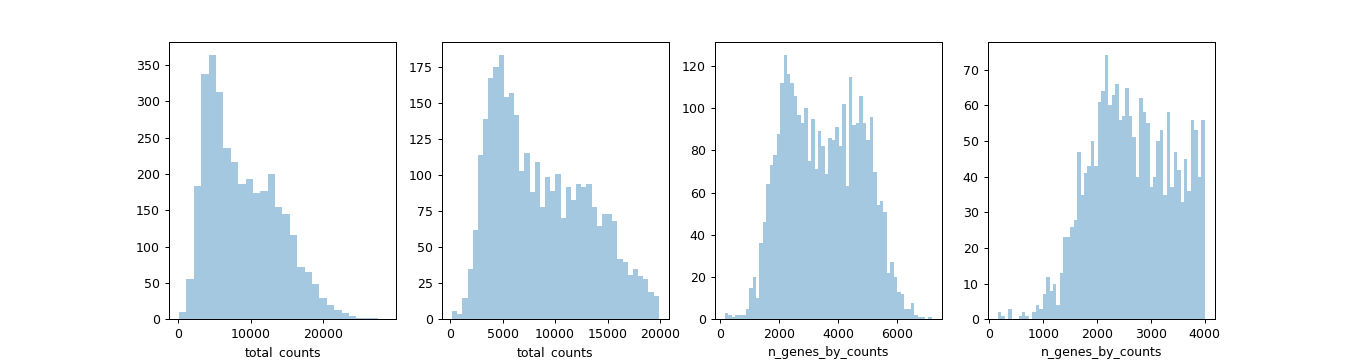

/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


<IPython.core.display.Javascript object>


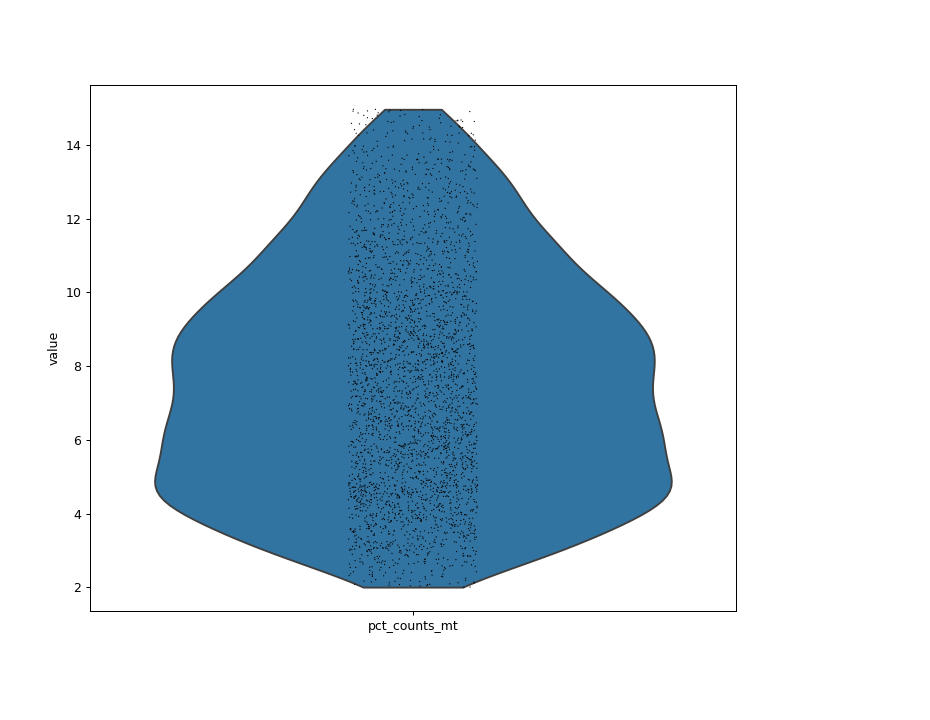

In [9]:
#Visualise some QC metrics for the data
%matplotlib notebook

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(ff_human_ovarian_cancer.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ff_human_ovarian_cancer.obs["total_counts"][ff_human_ovarian_cancer.obs["total_counts"] < 20000], kde=False, bins=40, ax=axs[1])
sns.distplot(ff_human_ovarian_cancer.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(ff_human_ovarian_cancer.obs["n_genes_by_counts"][ff_human_ovarian_cancer.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
sc.pl.violin(ff_human_ovarian_cancer,['pct_counts_mt'])

In [10]:
ff_human_ovarian_cancer

AnnData object with n_obs × n_vars = 3326 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [11]:
#Perform some filtering
sc.pp.filter_cells(ff_human_ovarian_cancer, min_counts=2000)
print(f'Number of cells after min count filter: {ff_human_ovarian_cancer.n_obs}')
sc.pp.filter_cells(ff_human_ovarian_cancer, max_counts=20000)
print(f'Number of cells after max count filter: {ff_human_ovarian_cancer.n_obs}')
ff_human_ovarian_cancer = ff_human_ovarian_cancer[ff_human_ovarian_cancer.obs["pct_counts_mt"] < 15]
ff_human_ovarian_cancer = ff_human_ovarian_cancer[ff_human_ovarian_cancer.obs["pct_counts_mt"] > 2]
print(f"#cells after MT filter: {ff_human_ovarian_cancer.n_obs}")
#Filter out genes that are detected in less than 10 cells
sc.pp.filter_genes(ff_human_ovarian_cancer, min_cells=10)
print(f'Number of genes after cell filter: {ff_human_ovarian_cancer.n_vars}')
sc.pp.filter_cells(ff_human_ovarian_cancer, min_genes = 2000)
print(f'Number of cells after gene filter: {ff_human_ovarian_cancer.n_obs}')

Number of cells after min count filter: 3275
Number of cells after max count filter: 3207
#cells after MT filter: 3207


/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Number of genes after cell filter: 17795
Number of cells after gene filter: 2837


In [12]:
##Do normalisation and find highly variable genes
sc.pp.normalize_total(ff_human_ovarian_cancer, inplace=True)
sc.pp.log1p(ff_human_ovarian_cancer)
sc.pp.highly_variable_genes(ff_human_ovarian_cancer, flavor="seurat", n_top_genes=2000)

<IPython.core.display.Javascript object>


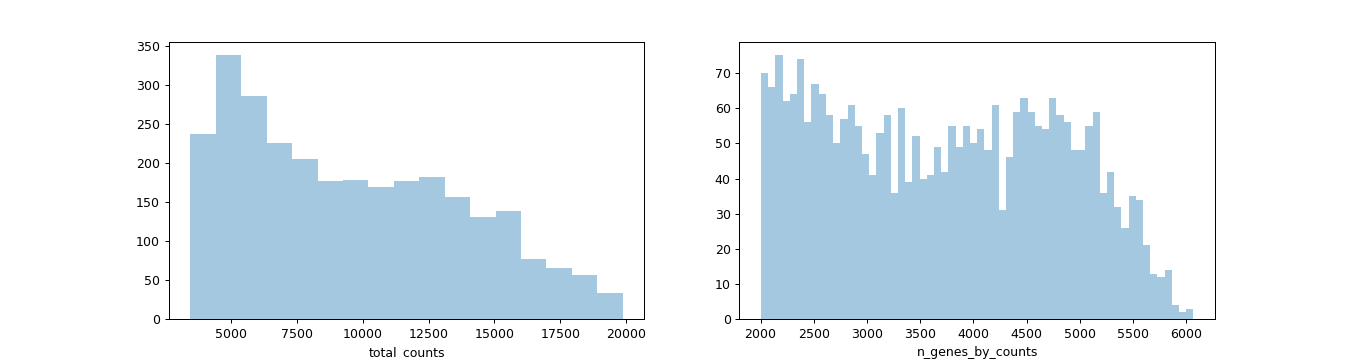

/Users/nataliecharitakis/opt/anaconda3/envs/spatialde/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

In [13]:
#Look at same plots after filtering an normalisation
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(ff_human_ovarian_cancer.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ff_human_ovarian_cancer.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

In [14]:
#Perform next steps in cluster identification
sc.pp.pca(ff_human_ovarian_cancer,n_comps=20)
sc.pp.neighbors(ff_human_ovarian_cancer)
sc.tl.umap(ff_human_ovarian_cancer)
sc.tl.leiden(ff_human_ovarian_cancer, key_added='clusters')

<IPython.core.display.Javascript object>


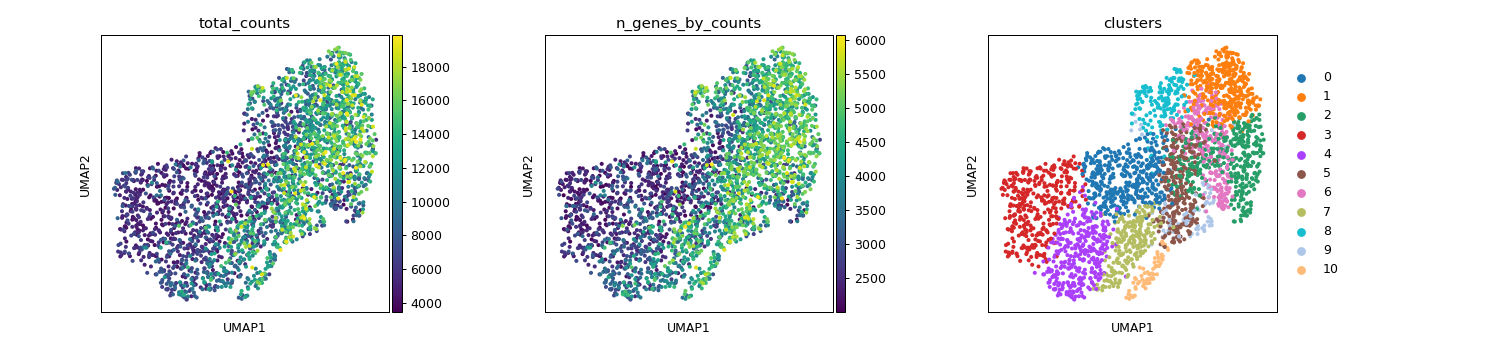

In [15]:
#Plot UMAPs
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ff_human_ovarian_cancer, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

<IPython.core.display.Javascript object>


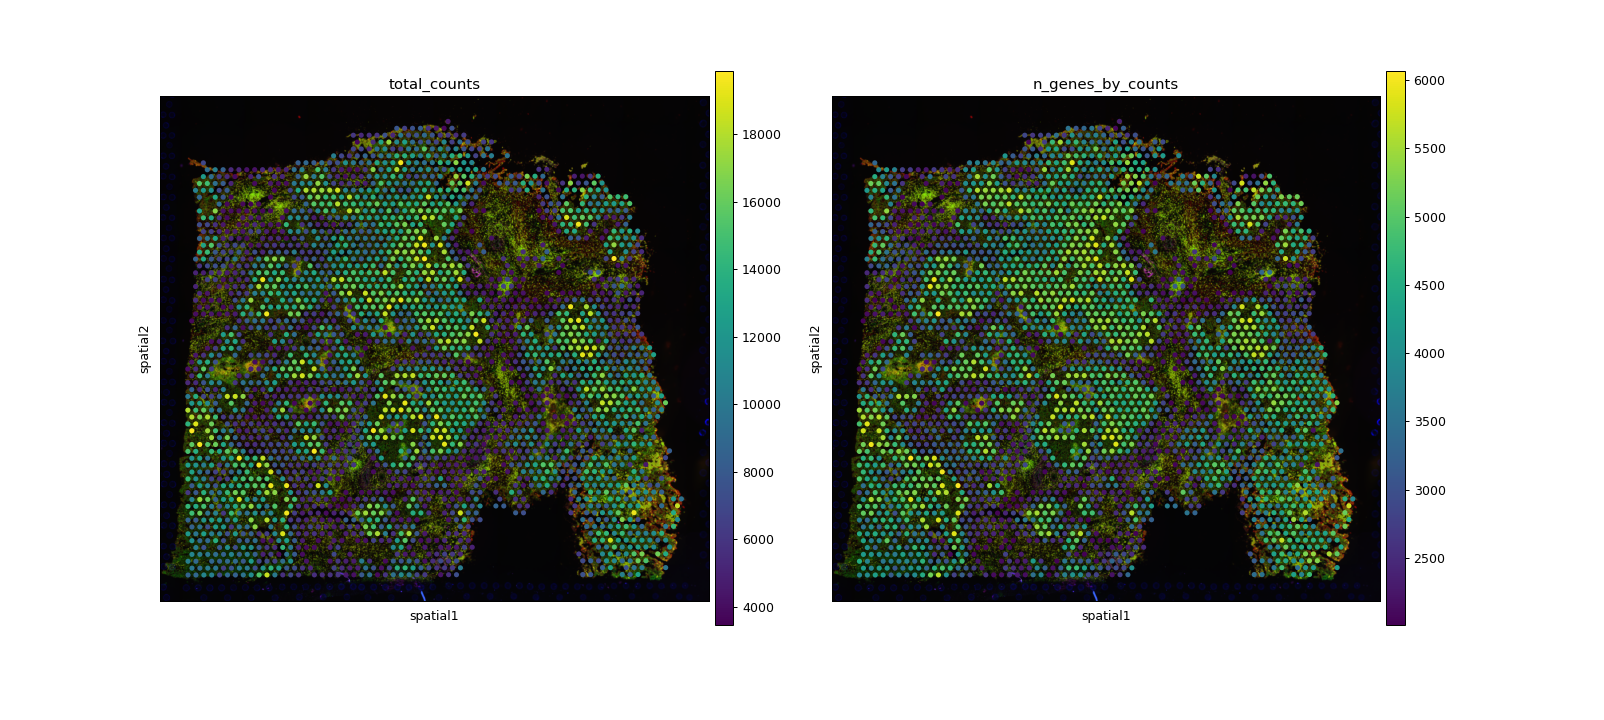

In [16]:
#Visualise metrics in spatial coordinates
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(ff_human_ovarian_cancer, img_key="hires", color=["total_counts", "n_genes_by_counts"])

<IPython.core.display.Javascript object>


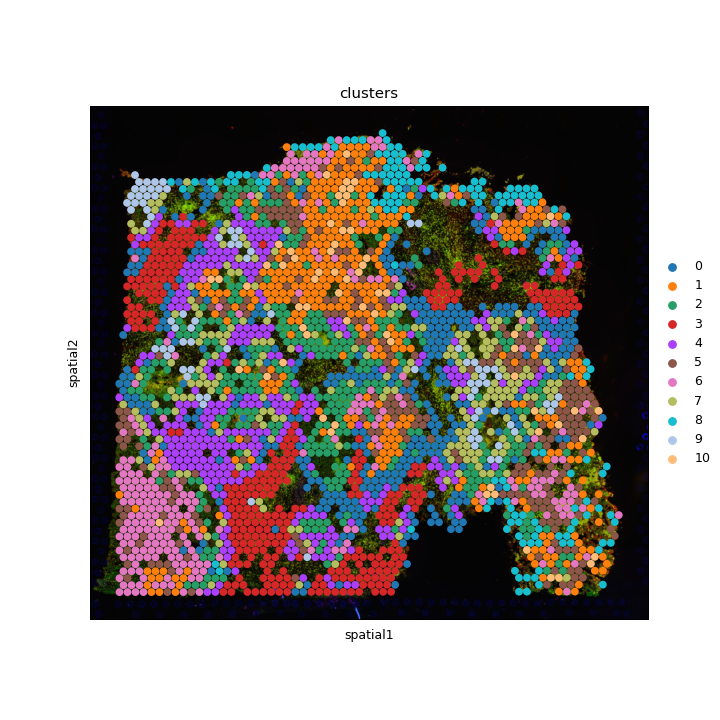

In [17]:
#Visualise cell type clusters on image of. tissue
sc.pl.spatial(ff_human_ovarian_cancer, img_key="hires", color="clusters", size=1.5)

<IPython.core.display.Javascript object>


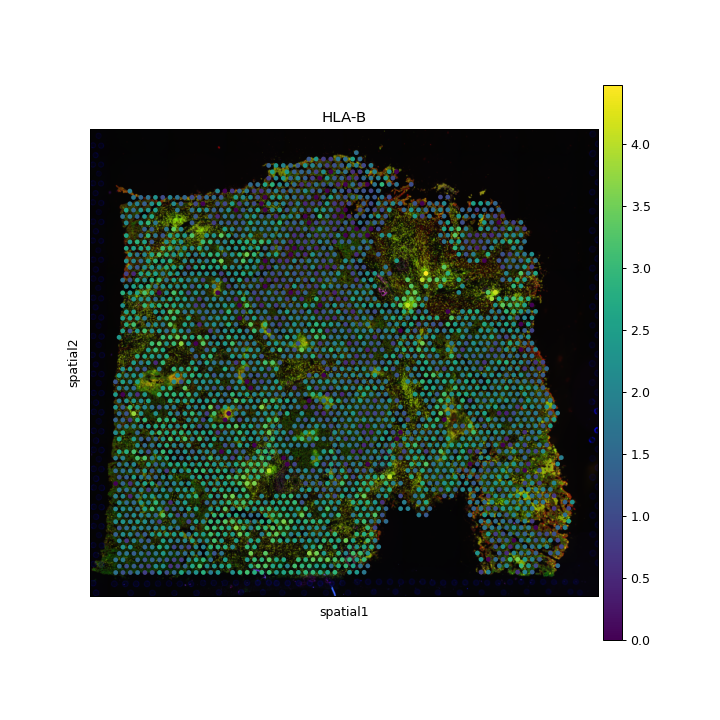

In [18]:
#Visualise expression of a particular gene across tissue
sc.pl.spatial(ff_human_ovarian_cancer, img_key = "hires", color="HLA-B")

#### Write out necessary output files

In [19]:
#ff_human_ovarian_cancer.write_csvs('.',skip_data=False)

In [ ]:
##write this AnnData object to  h5ad file
#ff_human_ovarian_cancer.write_h5ad(filename='ff_ovarian_cancer_procesed.h5ad', compression=None, compression_opts=None, force_dense=None, as_dense=())

### Now perform SVG analysis with SpatialDE

In [21]:
%%time
#Now try and find SVGs with SpatialDE
#We need to convert normalised counts into a DF for spatial DE

counts = pd.DataFrame(ff_human_ovarian_cancer.X.todense(), columns=ff_human_ovarian_cancer.var_names, index=ff_human_ovarian_cancer.obs_names)
coord = pd.DataFrame(ff_human_ovarian_cancer.obsm['spatial'], columns=['x_coord', 'y_coord'], index=ff_human_ovarian_cancer.obs_names)
results = SpatialDE.run(coord, counts)
results.to_csv('stat_analysis/ff_ovarian_cancer_spatialde_all_svgs.csv')

/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/17795 [00:00<?, ?it/s]

  0%|          | 0/17795 [00:00<?, ?it/s]

  0%|          | 0/17795 [00:00<?, ?it/s]

  0%|          | 0/17795 [00:00<?, ?it/s]

  0%|          | 0/17795 [00:00<?, ?it/s]

  0%|          | 0/17795 [00:00<?, ?it/s]

  0%|          | 0/17795 [00:00<?, ?it/s]

  0%|          | 0/17795 [00:00<?, ?it/s]

  0%|          | 0/17795 [00:00<?, ?it/s]

  0%|          | 0/17795 [00:00<?, ?it/s]

CPU times: user 15min 22s, sys: 4.81 s, total: 15min 27s
Wall time: 15min 27s


In [22]:
#Sort results for all qvals >= 0.05 and add them to file
results_filtered = results[results["qval"] <= 0.05]
results_filtered = results_filtered.sort_values(by="qval")
results_filtered.to_csv('ff_ovarian_cancer_svgs_spatialde.csv')
results_filtered

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
8262,0.364361,4,ACTB,928.985387,1.706435,-861.600888,3.191574,0.235411,SE,2837,0.000021,0.000451,0.002082,1755.003786,-1349.778944,488.178056,0.000000,0.000000
7466,0.384594,4,RPS7,490.809293,1.590038,-1479.095063,2.518043,0.415003,SE,2837,0.000006,0.000120,0.002346,2989.992135,-1882.534179,403.439117,0.000000,0.000000
7473,0.776063,4,IGKC,490.809293,0.286733,-3641.069842,2.109306,1.791601,SE,2837,0.000001,0.000036,0.002163,7313.941694,-5478.096756,1837.026913,0.000000,0.000000
7475,0.447451,4,RPL31,490.809293,1.227082,-863.143381,2.979787,0.544465,SE,2837,0.000005,0.000098,0.002265,1758.088771,-1385.938163,522.794782,0.000000,0.000000
7479,0.468950,4,COL3A1,490.809293,1.125272,-3717.791766,1.630655,0.677521,SE,2837,0.000005,0.000089,0.001975,7467.385543,-4335.492177,617.700410,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15300,0.020837,4,NSMCE1,3328.136212,37.229514,-1494.472626,0.269005,0.004611,SE,2837,0.000110,0.200491,0.003484,3020.747262,-1501.050041,6.577415,0.010328,0.049632
4908,0.337731,4,SIPA1L1,137.000000,1.960448,-1126.055767,0.211799,0.056232,SE,2837,0.001478,0.033047,0.001824,2283.913543,-1132.627017,6.571251,0.010364,0.049791
12343,0.022657,4,MCUR1,3328.136212,34.175957,-1623.171294,0.342989,0.005562,SE,2837,0.000169,0.261723,0.002587,3278.144597,-1629.736690,6.565397,0.010398,0.049942
14967,0.010279,4,PLCB2,3328.136212,76.286180,404.374314,0.063328,0.000581,SE,2837,0.000030,0.216422,0.003300,-776.946619,397.809734,6.564580,0.010403,0.049951
